## Part 1: Load Libaries and Import necessary dataset

In [1]:
# https://otexts.com/fpp3/prophet.html
# Load required libraries. Make sure to install them too
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)
library(zoo) # use for date formatting 
library(stats) # use for additive
library(caret)
library(glmnet)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: rlang


Attaching package: ‘Metrics’


The following object is masked from ‘package:rlang’:

    ll


The following object is masked from ‘package:forecast’:

    accuracy



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:Metrics’:

    precision, recall


Loading re

In [2]:
# Extract deposit_levels to use it in this file
deposit_levels <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/deposit_levels.rds") # Load the data


In [3]:
# Extract regressors_data to use it in this file
regressors_data <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/regressors_data.rds")

In [4]:
glimpse(deposit_levels)

Rows: 162
Columns: 2
$ time     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "1985Q2", "…
$ deposits <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 256737460…


## Part 2: Data Exploration for Prophet Assumption

### Step 1: Data Regularity and Sufficient Historical Data Expectation

- **Purpose**: Prophet requires data to be regular (no gaps in time periods) and free of missing values to build accurate forecasts.

In [5]:
sum(is.na(deposit_levels))  # no missing values

[1] 0

- The time series has regular quaterly intervals and no missing values so the data regurlarity expectation is satified. 

- It also has decades worth of data so the "sufficient historical data" expectation is satisfied. 

### Step 2: Presence of Trend Expectation

- **Purpose**: Prophet models require a clear understanding of the trend to accurately forecast future values. 

- **Next Steps**: Evaluate whether the data exhibits a linear or logistic trend.

- **Question** Does the choice of a linear trend or logistic trend affect Prophet's predictions?

- **Answer** : Yes, it absolutely affects the predictions. Here’s how:

    - **Linear Trend**: Assumes that growth continues indefinitely at a constant rate.
        - Future predictions will show a strong upward trend, even if the data is slowing down.
        - Example: If you fit a linear trend to deposit levels, Prophet will extrapolate a steadily increasing deposit level far into the future.

    - **Logistic Trend**: Assumes growth slows as it approaches a saturation point. 
        - Future predictions will show a more tamed upward trend, leveling off over time.
        - Example: If deposits are approaching a plateau, a logistic trend will reflect that in future predictions, ensuring the model doesn't over-predict growth.

- **Key Insight**:If you fit Prophet with the wrong trend type (e.g., linear when the data shows signs of saturation), your forecasts will misrepresent the future. Context is critical here: If you know from domain expertise or external analysis that growth will saturate, using a logistic trend will give more realistic predictions.

#### a. Formatting the time as a date instead of a character and also have anumeric format of the date

In [6]:
# Step 1: Format time as date 
# Format
time <- as.Date(as.yearqtr(deposit_levels$time, format = "%YQ%q"))
# Add the formatted date back into the dataset
deposit_levels$time_as_date <- time

# Step 2: Format time as numeric
# Format
time2 <- as.numeric(deposit_levels$time_as_date)
#  Add the formatted date back into the dataset
deposit_levels$time_as_numeric <- time2

# Check
glimpse(deposit_levels)

Rows: 162
Columns: 4
$ time            <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "198…
$ deposits        <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 25…
$ time_as_date    <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 1985-…
$ time_as_numeric <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 5752, 5844, …


In [7]:
saveRDS(deposit_levels, "deposits.rds")  # Save the data to call it in other notebooks

#### b. Visualizing Linear Trend

`geom_smooth()` using formula = 'y ~ x'


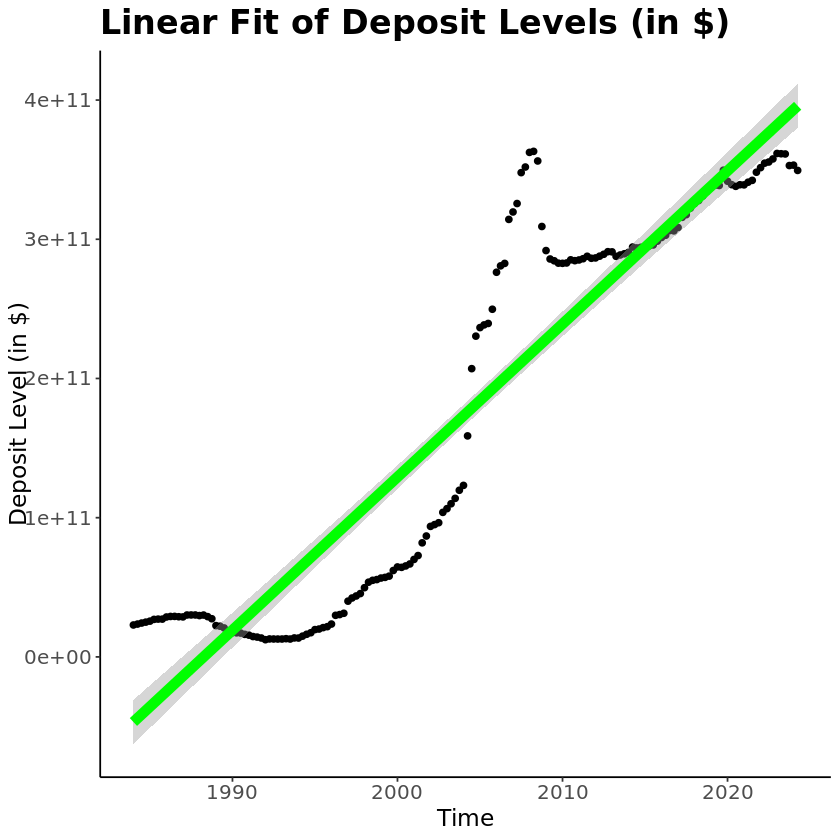

In [8]:
# Step 1: Time needs to be formatted as numeric for it to work ==> DONE above

# Step 2: Fit the linear model
linear_model <- lm(deposits ~ time_as_numeric ,data = deposit_levels) # Use time as numeric here

# Step 3: Plot the model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) + 
  geom_point() +
  geom_smooth(method = lm, col = "green", linewidth = 3) + 
  labs(title = "Linear Fit of Deposit Levels (in $)", 
       x = "Time", 
       y = "Deposit Level (in $)") +
  theme_classic() + 
  theme(
    plot.title = element_text(size = 20, face = "bold"), # Increase title size
    axis.title.x = element_text(size = 14),             # Increase x-axis label size
    axis.title.y = element_text(size = 14),             # Increase y-axis label size
    axis.text = element_text(size = 12)                 # Increase axis tick labels size
  )

#### c. Visualizing Logistic Growth Trend

- Not the same as logistic resgression

- A mathematical model used to describe non-linear growth that slows as it approaches a saturation point.

Warning message in geom_point(color = "black", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”


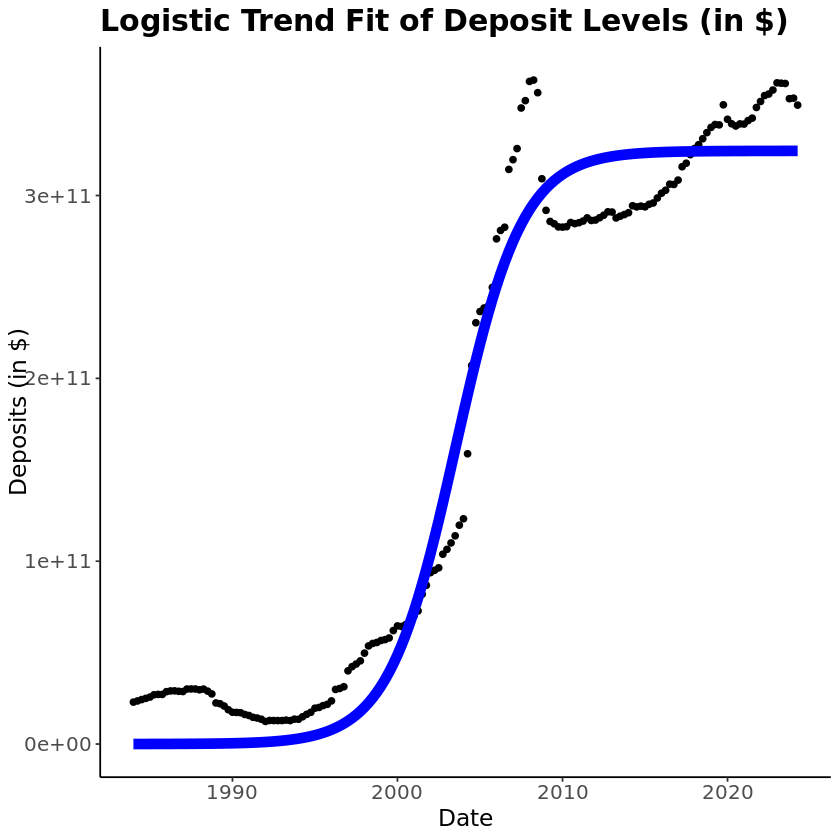

In [9]:
# Step 1: Define a logistic function
logistic_function <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))  # L = carrying capacity, k = growth rate, x0 = midpoint
}

# Step 2: Fit the logistic model
logistic_model <- nls(deposits ~ logistic_function(time_as_numeric, L, k, x0),
                      data = deposit_levels,
                      start = list(L = max(deposit_levels$deposits), k = 0.01, x0 = median(deposit_levels$time_as_numeric)))


# Step 3: Add logistic trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(logistic_trend = predict(logistic_model))

# Step 4: Plot the linear model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) +
  geom_point(color = "black", linewidth = 1) +  # Actual data
  geom_line(aes(y = logistic_trend), color = "blue", linewidth = 3) +  # Logistic trend
  labs(title = "Logistic Trend Fit of Deposit Levels (in $)", 
       x = "Date", 
       y = "Deposits (in $)") +
  theme_classic() +  # Simplify the appearance
  theme(
    plot.title = element_text(size = 18, face = "bold"), # Increase title size
    axis.title.x = element_text(size = 14),             # Increase x-axis label size
    axis.title.y = element_text(size = 14),             # Increase y-axis label size
    axis.text = element_text(size = 12)                 # Increase tick label size
  )


#### d. Conclusion for Trend

**Why NOT logistic trend model?**

- Even though, the logistic trend line seems to fit better past data, the logistic trend assumes market saturation and plateau. 
- But due to contextual information we have, we know that this is not a plateau but the slow growth was due to the 2008 crisis which is a one time event and not a recurring structural pattern.
- If we pick logistic trend, it might lead to under-predictions if the future involves a period of growth.
- This highlights the importance of blending data patterns with domain insights. A blind reliance on "best fit" could lead to a misinterpretation of the trends.

**Why pick linear trend fit?**
- Linear trends assume consistent growth over time, which aligns well with long-term economic expansion and deposit accumulation in a stable financial system
- Plus, current high interest rate environment incentivizes deposits.
- We see a continued economic recovery post 2008 crisis, suggesting deposits will grow, though slower than pre-crisis period.
- Uncertainty about inflation and the economy may drive precautionary savings since we are also recovering from the covid 19 crisis.
- Ultimately, choosing linear growth aligns with the economic rationale that deposits will likely grow as part of the recovery phase. 

**Additional Data Manipulation?**
- Will we have to use log? Or will that change the linearity?
- Applying a log transformation to your data can help make it fit better if your deposit levels grow exponentially rather than linearly. However, this doesn't change the fact that you're still modeling a linear trend—it just adjusts the scale to make it easier for Prophet to handle the data
- If your data already behaves linearly, logging may unnecessarily distort it. ==> I think it's fine


 


In [10]:
# Code to check for linearit assumption
linear_model1 <- lm(deposits ~ time_as_numeric, data = deposit_levels) # Linearity is struggling due to changepoints but I can add changepoints to prophet
#plot(linear_model1)
# Transform with log and see if it's better
linear_model2 <- lm(log(deposits) ~ time_as_numeric, data = deposit_levels) # No it did not help improve
#plot(linear_model2)


### Step 3: Seasonality Expectation

- Tools like Prophet and others can explicitly model seasonality if detected, which improves forecasting by capturing these periodic variations.

- However it's important to manually double check and understand the context behind the model.

- If seasonality exists but isn’t accounted for in the model, predictions may be inaccurate.

- For instance, if deposits consistently increase in Q4 but your model doesn’t include seasonality, it will underestimate future deposits in that quarter.

#### a. Let's plot a detrended ACF to check for seasonality

**How to read an ACF Plot**

- We look at the peaks that go above the blue line. Check lags based on the frequency:
   - Lag = 12 for monthly data (12 months in a year)
   - Lag = 4 for quarterly data
   - Lag = 52 for weekly data

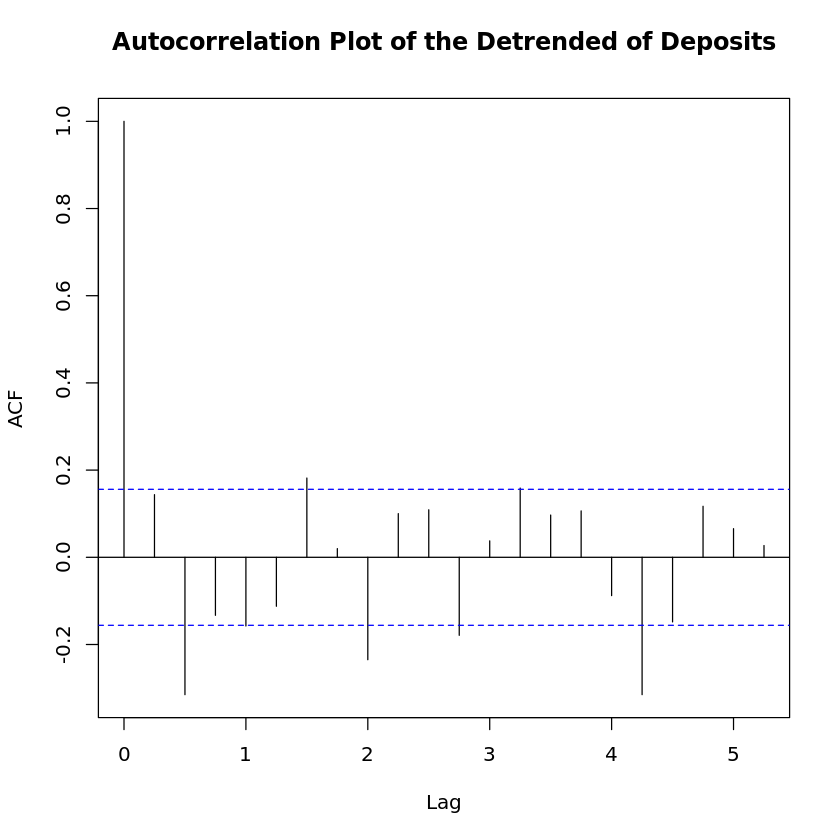

In [11]:
# Step 1: Convert deposits into a time series object. ACF only takes in time series data. 
deposit_time_series <- ts(deposit_levels$deposits, 
                        start = c(1984, 1), # we could have put deposit_levels$time_as_numeric but later on when plotting randomness the x axis won't show time properly so we just hardcode to tell where X axis will start and with frequency it knows how to link X and Y. 
                        frequency = 4) # Quarterly frequency 

# Step 2: Subtract the trend component, since the trend dominates, remove it to isolate the seasonality
        # Decompose the trend: breaks down the trend
deposit_decompose_trend <- decompose(deposit_time_series, type="additive") # breaks down dataset into 4 categories: observed data, trend, seasonality and randomness plot(deposit_decompose_trend) to see all 4 
        # Remove the trend from the time series data
deposit_detrended <- deposit_time_series - deposit_decompose_trend$trend

# Step 3: Plot ACF to check for seasonality
acf(deposit_detrended, na.action = na.omit, main = "Autocorrelation Plot of the Detrended of Deposits") # NAs comes from decomposition algorithm uses a moving window to calculate the trend, and it cannot compute values for the edges of the series.

#### b. Conclusion for Seasonality

- There are no peaks above the blue line at lag 4 (Quarterly Seasonality), the absence of such spikes suggests that quarterly seasonality is weak or not present in this case.

- For now, we will let Prophet's built-in seasonal detection handle any weak seasonal patterns

### Step 4: Outliers Expectation

**Why check for outliers**:  

- Prophet is designed to handle outliers and is fairly robust to their presence.

- However, extreme anomalies (like sudden, sharp increases or drops) can still affect the trend and seasonal components, distorting predictions.

In [12]:
# Check steps here: https://sqlpad.io/tutorial/interquartile-range/#:~:text=The%20standard%20method%20involves%20calculating,these%20bounds%20are%20potential%20outliers.

# Step 1: Calculate the IQR
IQR_value <- IQR(deposit_levels$deposits)

# Step 2: Define Boundaries
lower_bound <- quantile(deposit_levels$deposits, 0.25) - 1.5 * IQR_value
upper_bound <- quantile(deposit_levels$deposits, 0.75) + 1.5 * IQR_value

# Step 3: Flag Outliers
outliers <- subset(deposit_levels, deposits < lower_bound | deposits > upper_bound)

# step 4: Print Outliers
outliers

time,deposits,time_as_date,time_as_numeric,logistic_trend
<chr>,<dbl>,<date>,<dbl>,<dbl>



**Conclusion for Outliers:**

- Based of the results, it looks like the IQR method did not flag any outliers in the data. The deposit levels in the dataset fall within the acceptable range defined by the IQR method. The deposit levels may be naturally smooth without extreme spikes or dips (maybe lol?)

- Even without detected outliers, we should remain aware of contextual anomalies (e.g., the 2008 crisis) that could still affect model interpretation and trends.

### Step 5: Noise


**Why check for noise?**

- Noise refers to the unexplained or irrelevant variation in the data that cannot be attributed to meaningful patterns.
- Prophet is robust to noise, but excessive noise may require preprocessing (e.g., smoothing).
- A higher proportion (close to 1) indicates the data is dominated by noise.
- A lower proportion (closer to 0) means the data has more structured patterns (e.g., trend, seasonality).

In [13]:
# Calculate the variance of the residuals to quantify the noise and Compare this variance to the overall variance in the observed data.

# Variance of residuals (randomness)
residual_variance <- var(deposit_decompose_trend$random, na.rm = TRUE) # Use our decomposed dataset

# Variance of the original data
observed_variance <- var(deposit_time_series, na.rm = TRUE)  # Use our dataset that was transformed to time series, if we use deposit_levels directly it won't work

# Proportion of variance due to noise
global_noise_proportion <- residual_variance / observed_variance
global_noise_proportion

[1] 0.0006678225

**Conclusion for Noise**

- Our noise proportion of approximately 0.00067 (a very small number), which means: noise contributes very little to the overall variability in your data. 
- This is typical seen when our data has a strong long-term trend.
- So there won't be any need for excessive smoothing or denoising steps. Prophet can effectively handle the low-level noise.

#### Step 6: Localised Randomness

**Why check for randomness?**

-  Randomness, as shown in decomposition, includes localized irregularities or residual variations that aren't explained by the trend or seasonality but may include event-driven or one-off effects (like the 2008 crisis). It’s more localized and descriptive of specific periods rather than a global property like noise.
- While Prophet is robust to some noise, high randomness (localized irregularities) can make it harder to discern meaningful patterns.

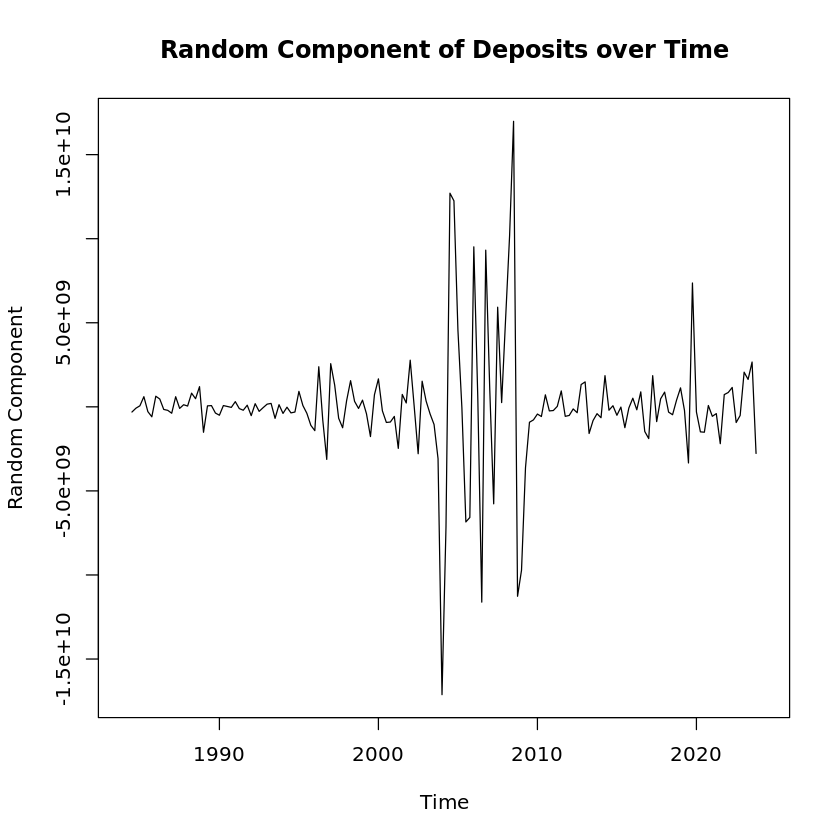

In [14]:
# plot(deposit_decompose_trend) ==> from the ACF code above in step 3.a

plot(deposit_decompose_trend$random,
    xlab = "Time",
    ylab = "Random Component",
    main = "Random Component of Deposits over Time")

**Conclusion for Randomness**
- There is significant randomness during the 2008 crisis period.
- We can add on a changepoint to handle abrupt trend changes.
- Prophet will automatically detects changepoints in the trend. However, you can manually specify changepoints (e.g., around 2008) where the data exhibits high variability.


## Part 3: Forecasting with Prophet

### Step 1: Split Data between training and test data

In [15]:
train_data <- deposit_levels[deposit_levels$time_as_date <= "2019-12-31", ]  # Training data: 1984 Q1 to 2020 Q4
test_data <- deposit_levels[deposit_levels$time_as_date > "2019-12-31", ]  # Testing data: 2021 Q1 to 2024 Q2

# Check
#View(train_data)
#View(test_data)


### Step 2: Prepared the Data

In [16]:
# Step 1: Prepare data for prophet to work

# you have to rename them as ds and y for prophet to work and it will automatically ignore all other columns ==> RULE
train_data$ds <- as.Date(train_data$time_as_date)
train_data$y <- train_data$deposits

test_data$ds <- as.Date(test_data$time_as_date)
test_data$y <- test_data$deposits

### Step 3: Fit Prophet on training data

In [17]:
# Step 1: Initialize the model
prophet_model<- prophet(changepoints = c("2008-01-01")) # Add Customizations based on assumptions made above https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors
# We can later add on additional regressor to the best model

# Step 2: Fit the model: Training the model
prophet_model <- fit.prophet(prophet_model, train_data) # syntax


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Warning message in .local(object, ...):
“non-zero return code in optimizing”
Optimization terminated abnormally. Falling back to Newton optimizer.



### Step 4: Create a Future Dataframe

In [18]:
future_train_data <- make_future_dataframe(prophet_model, periods = 33, freq = "quarter") # start counting from the end of the training data: 2020 Q4 to 2028 Q1
#future_train_data # The output of make_future_dataframe() will include both the training data dates and the newly created future dates.

In [19]:
#future_train_data

### Step 5: Predict Future Values

In [20]:
prediction_train_data <- predict(prophet_model, future_train_data)

In [21]:
#prediction_train_data

### Step 6: Visualize the Forecast

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


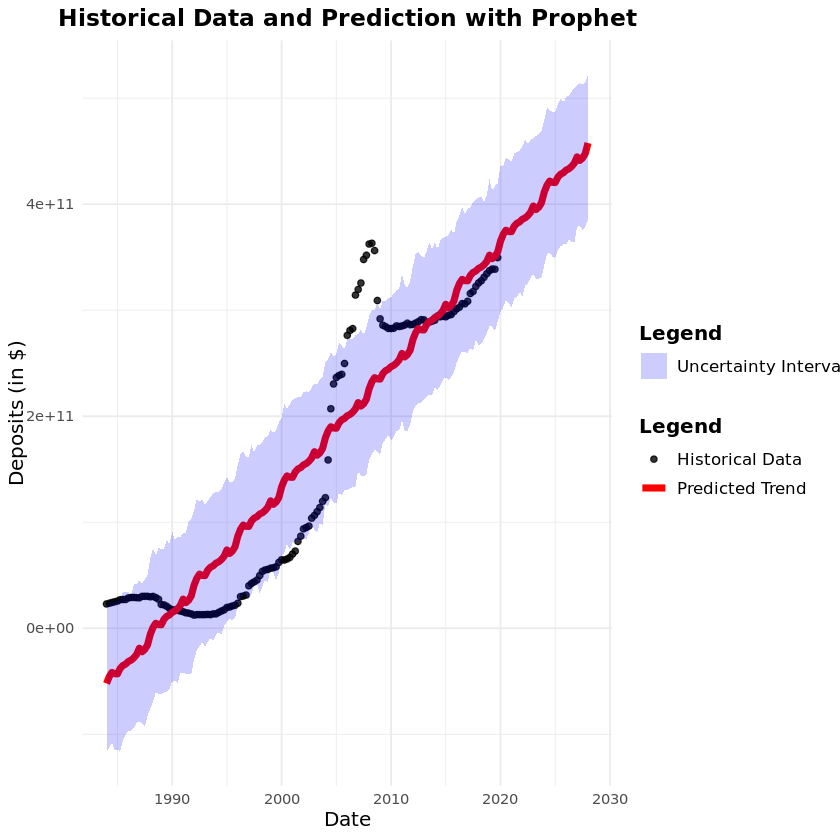

In [22]:
# Ensure 'ds' is a Date object
train_data$ds <- as.Date(train_data$ds)
prediction_train_data$ds <- as.Date(prediction_train_data$ds)

ggplot() +
  # Add historical data points
  geom_point(data = train_data, aes(x = ds, y = y, color = "Historical Data"), size = 1.5, alpha = 0.8) +
  # Add the predicted trend line
  geom_line(data = prediction_train_data, aes(x = ds, y = yhat, color = "Predicted Trend"), size = 2) +
  # Add uncertainty intervals for predictions
  geom_ribbon(
    data = prediction_train_data,
    aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Uncertainty Interval"),
    alpha = 0.2
  ) +
  # Add labels and a title
  labs(
    title = "Historical Data and Prediction with Prophet",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend",
    fill = "Legend"
  ) +
  # Customize colors for the legend
  scale_color_manual(
    values = c("Historical Data" = "black", "Predicted Trend" = "red")
  ) +
  scale_fill_manual(
    values = c("Uncertainty Interval" = "blue")
  ) +
  # Add a minimal theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  )

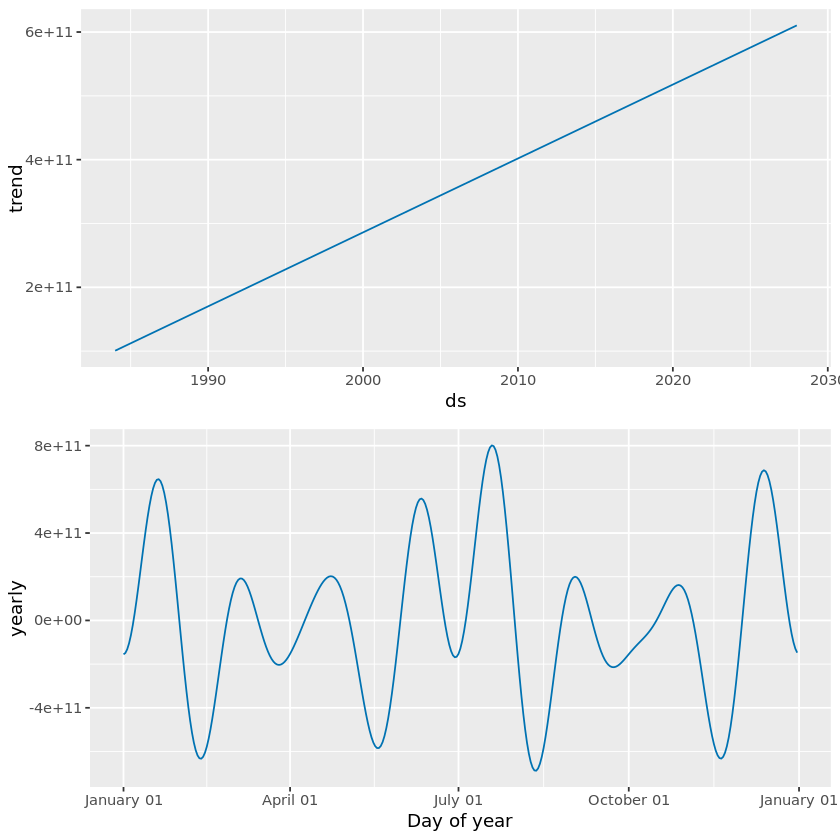

In [23]:
prophet_plot_components(prophet_model, prediction_train_data)

## Part 4: Evaluation of the Model Performance

### Step 1: Compare predictions with test data 

- The test data is unseen data (not used in training) that allows you to assess how well your model generalizes to new data.
- Comparing predictions to actual values in the test data helps identify whether the model overfits or underfits.
- A good forecast should perform well not only on the training data but also on the test data. This is a crucial check before relying on the model for real-world forecasting.

In [24]:
#glimpse(test_data)

# Step 1: Create future dataframe for test data
future_test_data <- make_future_dataframe(prophet_model, periods = nrow(test_data), freq = "quarter") # Testing data: 2021 Q1 to 2024 Q2
#future_test_data

# Step 2: Make predictions for the test data
prediction_test_data <- predict(prophet_model, future_test_data) 
prediction_test_data$ds <- as.Date(prediction_test_data$ds) #make sure ds is in date format or else merge will fail

In [25]:
prediction_test_data

ds,trend,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,100627696878,-152702947604,-152702947604,-152702947604,-152702947604,-152702947604,-152702947604,0,0,0,-122385352017,14653983467,100627696878,100627696878,-52075250726
1984-04-01,103514358350,-149135695682,-149135695682,-149135695682,-149135695682,-149135695682,-149135695682,0,0,0,-119738284065,22526585756,103514358350,103514358350,-45621337332
1984-07-01,106401019822,-148079914934,-148079914934,-148079914934,-148079914934,-148079914934,-148079914934,0,0,0,-107691268867,26533475840,106401019822,106401019822,-41678895112
1984-10-01,109319402849,-152182711494,-152182711494,-152182711494,-152182711494,-152182711494,-152182711494,0,0,0,-109272253391,22996578886,109319402849,109319402849,-42863308645
1985-01-01,112237785876,-155266814735,-155266814735,-155266814735,-155266814735,-155266814735,-155266814735,0,0,0,-111063739840,27043238993,112237785876,112237785876,-43029028859
1985-04-01,115092725793,-153000674265,-153000674265,-153000674265,-153000674265,-153000674265,-153000674265,0,0,0,-102278359614,26190568567,115092725793,115092725793,-37907948471
1985-07-01,117979387265,-153116768261,-153116768261,-153116768261,-153116768261,-153116768261,-153116768261,0,0,0,-109661544491,32349448764,117979387265,117979387265,-35137380996
1985-10-01,120897770292,-154711973907,-154711973907,-154711973907,-154711973907,-154711973907,-154711973907,0,0,0,-99513152737,39144238636,120897770292,120897770292,-33814203615
1986-01-01,123816153319,-155102980826,-155102980826,-155102980826,-155102980826,-155102980826,-155102980826,0,0,0,-98176783931,35513409648,123816153319,123816153319,-31286827507


In [26]:
# Step 3: Merge predictions with actual test data: 
# The merging step combines your actual test data with the predictions generated by Prophet. This creates a single dataframe where you can directly compare the actual (y) and predicted (yhat) values for each time point (ds)
prediction_test_results <- merge(test_data, prediction_test_data[, c("ds", "yhat")], by = "ds")
prediction_test_results

#test_data
#prediction_test_data

ds,time,deposits,time_as_date,time_as_numeric,logistic_trend,y,yhat
<date>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-01,2020Q1,341691380000,2020-01-01,18262,324321069638,341691380000,365031471210
2020-04-01,2020Q2,339227043000,2020-04-01,18353,324332322621,339227043000,371485384603
2020-07-01,2020Q3,338020161000,2020-07-01,18444,324342277848,338020161000,375427826823
2020-10-01,2020Q4,339166813000,2020-10-01,18536,324351175827,339166813000,374243413290
2021-01-01,2021Q1,339070926000,2021-01-01,18628,324359036936,339070926000,374077693076
2021-04-01,2021Q2,340991443000,2021-04-01,18718,324365839949,340991443000,379198773463
2021-07-01,2021Q3,342317919000,2021-07-01,18809,324371929301,342317919000,381969340938
2021-10-01,2021Q4,348156945000,2021-10-01,18901,324377371839,348156945000,383292518319
2022-01-01,2022Q1,351425943000,2022-01-01,18993,324382180069,351425943000,385819894426


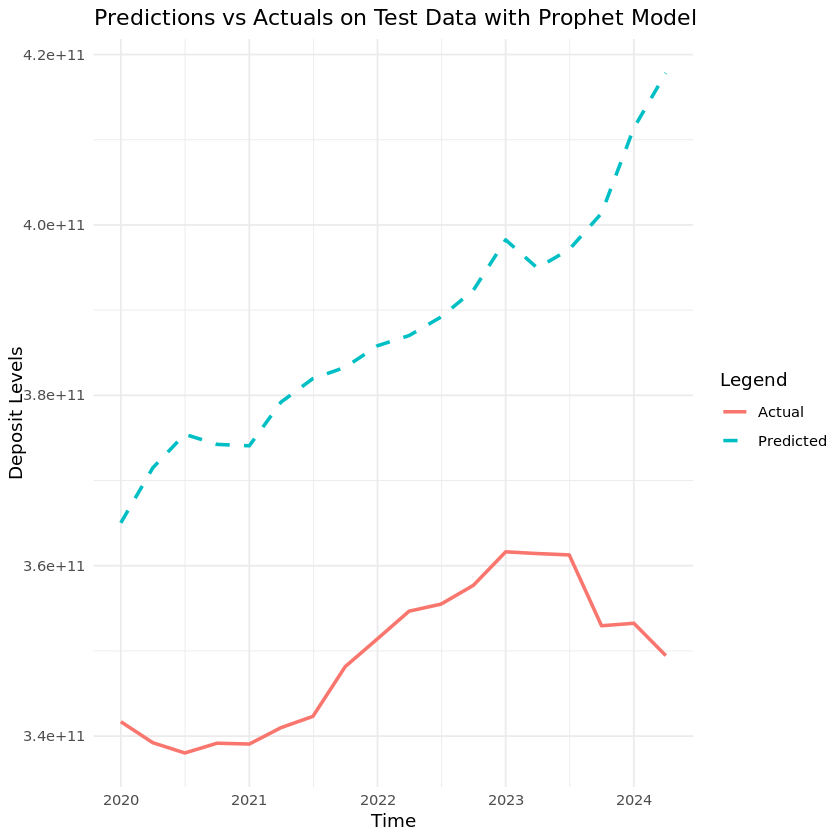

In [27]:
# Step 4: Plot the predictions vs actuals
ggplot(prediction_test_results, aes(x = ds)) +
  geom_line(aes(y = y, color = "Actual"), size = 1) + # Actual test data
  geom_line(aes(y = yhat, color = "Predicted"), size = 1, linetype = "dashed") + # Predictions
  labs(
    title = "Predictions vs Actuals on Test Data with Prophet Model",
    x = "Time",
    y = "Deposit Levels",
    color = "Legend"
  ) +
  theme_minimal()


**Observations**
- The predicted model (blue dashed line) done with Prophet does not closely align with the test (actual) data from 2021 to 2024. 
- There's a significant divergence between the actuals and predictions: the model overpredicts significantly in this range, showing an upward trend, whereas the actual values flatten or slightly decrease.

### Step 2. Compute Perfomance Metrics

- Necessary to be able to quantify the discrepancy between the actual data (test data) and the predicted data

In [28]:
# Mean Absolute Error (MAE)

actual <- prediction_test_results$y
predicted <- prediction_test_results$yhat

MAE_prophet <- mean(abs(actual - predicted))
MAE_prophet

# Root Mean Squared Error (RMSE)
RMSE_prophet <- sqrt(mean((actual - predicted)^2))
RMSE_prophet

# Mean Absolute Percentage Error (MAPE)
MAPE_prophet <- mean(abs(actual - predicted) / actual) * 100
MAPE_prophet

[1] 38449782904

[1] 39736668773

[1] 11.00521

- MAE = 36897, on average, our model's predictions are off by $36897 (Million) from the actual values.
- RMSE = 38141
- MAPE = 10%, on average our prediction are off by 10%. 

# Part 5: Adding on External Regressors to the Model

## Step 1: Select Relevant Features through domain knowledge

- Our goal here is research features that are likely to affect deposit level
- To narrow our options we will use a mix of domain knowledge and a LASSO regression to undertand the relationship between deposit and those potential regressors

> Here is a list of features through reserach and domain knowledge that I believe most impact deposit levels:
- GDP Growth Rate: Stronger economic growth can lead to higher income and savings
- Unemployment Rate: Higher unemployment can reduce deposits due to lower income
- Consumer Confidence Index: Reflects consumers' willingness to save vs. spend
- Population Growth: Larger populations in a region can increase deposit levels over time
- 10 Year Treasury Yield: Represent the interest rate environment, directly affecting deposit rates and competing as an alternative safe investment option.
- Federal Funds Effective Rate: impacts savings account interest rate
- Disposable Personal Income (percent change from year ago): ok
- Consumer Price Index (units: growth rate previos period in decimal): measure of inflation rate. Higher inflation may reduce disposable income and savings levels


## Step 2: Narrow Down Features through LASSO Regression

### A. Prepare the Data

- Combine deposit level data and regressors data into one => deposit_regressor_data
- Keeping the target variable (Deposit_Levels) untouched.
- Ensuring non-regressor columns (e.g., time) are excluded from scaling. time: A timestamp or date column (used for splitting but not for scaling or modeling).
- Scaling only the features (regressors). Other columns (GDP_Growth, Unemployment_Rate, Interest_Rate, SP500, etc.): Features to be scaled.

In [29]:
# Combine deposit level data and regressors data into one => deposit_regressor_data
deposit_regressor_data <- merge(deposit_levels, regressors_data, by = c("time_as_date", "time_as_numeric"))
glimpse(deposit_regressor_data)

Rows: 162
Columns: 13
$ time_as_date             <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-…
$ time_as_numeric          <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 575…
$ time                     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985…
$ deposits                 <dbl> 22917257000, 23575192000, 24308965000, 249679…
$ logistic_trend           <dbl> 21838214, 24686425, 27906077, 31588126, 35755…
$ population               <dbl> 235604667, 236082333, 236657333, 237232667, 2…
$ unemployment_rate        <dbl> 0.07866667, 0.07433333, 0.07433333, 0.0730000…
$ ConsumerPriceIndex       <dbl> 1.1202636, 1.0752688, 1.0960671, 0.7334184, 0…
$ DisposablePersonalIncome <dbl> 10729270000, 11779660000, 10982020000, 947008…
$ Yield                    <dbl> 0.11943333, 0.13200000, 0.12866667, 0.1174333…
$ fed_rate                 <dbl> 0.09686667, 0.10556667, 0.11390000, 0.0926666…
$ GDP                      <dbl> 3.908054e+12, 4.009601e+12, 4.084250e+12, 4.1…
$ GDP_growth_rate 

In [30]:
# Pre process only the regressors inside your data

# Exclude all that's not a regressor like the target varaiable (deposit) and time variables
regressors_col <- setdiff(names(deposit_regressor_data), c("logistic_trend", "time", "time_as_date", "time_as_numeric", "deposits"))

# The preProcess function centers (mean = 0) and scales (std = 1) your predictors => Apply scaling to the feature columns
pre_process_data <- preProcess(deposit_regressor_data[, regressors_col], method=c("center", "scale"))


## B. Split dataset into Training dataset and Test dataset

In [31]:
# Split data into training and testing based on time
train_data_regressor <- subset(deposit_regressor_data, time_as_date <= "2019-12-31") # Training data: 1984 Q1 to 2020 Q4
test_data_regressor <- subset(deposit_regressor_data, time_as_date > "2019-12-31")  # Testing data: 2021 Q1 to 2024 Q2


In [32]:
# Apply the pre-processing to our training and testing dataset

# Scale training data (apply preprocessing to the regressor columns only)
train_data_scaled <- train_data_regressor
train_data_scaled[, regressors_col] <- predict(pre_process_data, train_data_regressor[, regressors_col])

# Scale testing data using the same preprocessing parameters
test_data_scaled <- test_data_regressor
test_data_scaled[, regressors_col] <- predict(pre_process_data, test_data_regressor[, regressors_col])

In [33]:
#Check
glimpse(train_data_scaled)

Rows: 144
Columns: 13
$ time_as_date             <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-…
$ time_as_numeric          <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 575…
$ time                     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985…
$ deposits                 <dbl> 22917257000, 23575192000, 24308965000, 249679…
$ logistic_trend           <dbl> 21838214, 24686425, 27906077, 31588126, 35755…
$ population               <dbl> -1.723813, -1.708746, -1.690610, -1.672463, -…
$ unemployment_rate        <dbl> 1.218313013, 0.957802585, 0.957802585, 0.8776…
$ ConsumerPriceIndex       <dbl> 0.65970457, 0.58896015, 0.62166082, 0.0514752…
$ DisposablePersonalIncome <dbl> 2.04629596, 2.44325446, 2.14181406, 1.5704287…
$ Yield                    <dbl> 2.5907227, 3.0606998, 2.9360374, 2.5159252, 2…
$ fed_rate                 <dbl> 2.0758097, 2.3721988, 2.6560963, 1.9327254, 1…
$ GDP                      <dbl> -1.374682, -1.359221, -1.347855, -1.338065, -…
$ GDP_growth_rate 

In [34]:
regressors_col

[1] "population"               "unemployment_rate"       
[3] "ConsumerPriceIndex"       "DisposablePersonalIncome"
[5] "Yield"                    "fed_rate"                
[7] "GDP"                      "GDP_growth_rate"

### C. Fit the LASSO Model

In [35]:
# Create matrices for modeling for training data

X_train_lasso <- as.matrix(train_data_scaled[, regressors_col])
X_train_lasso[is.na(X_train_lasso)] <- 0 # fill the mssing value with 0
y_train_lasso <- train_data_scaled$deposits

# Create matrices for modeling for testing data
X_test_lasso <- as.matrix(test_data_scaled[, regressors_col])
y_test_lasso <- test_data_scaled$deposits


In [36]:
# Fit the lasso_model
lasso_model <- cv.glmnet(X_train_lasso, y_train_lasso, alpha = 1)
summary(lasso_model)

           Length Class  Mode     
lambda     77     -none- numeric  
cvm        77     -none- numeric  
cvsd       77     -none- numeric  
cvup       77     -none- numeric  
cvlo       77     -none- numeric  
nzero      77     -none- numeric  
call        4     -none- call     
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

In [37]:
# Extract selected features at lambda.min
selected_features <- coef(lasso_model, s = "lambda.min")
print(selected_features)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              193914862865
population                          .
unemployment_rate         31637026342
ConsumerPriceIndex         4136335856
DisposablePersonalIncome            .
Yield                               .
fed_rate                  32786591154
GDP                      194313307135
GDP_growth_rate          -10250663416


- You’ve chosen not to scale the deposits column, which is fine as long as you don’t intend to interpret the coefficients from the LASSO model directly. However, if coefficient interpretation is needed, it’s often better to scale the target variable as well (standardize deposits).
-  Lasso revealed that only unemployment rate and GDP are useful here.

### D. LINE Assaumptions

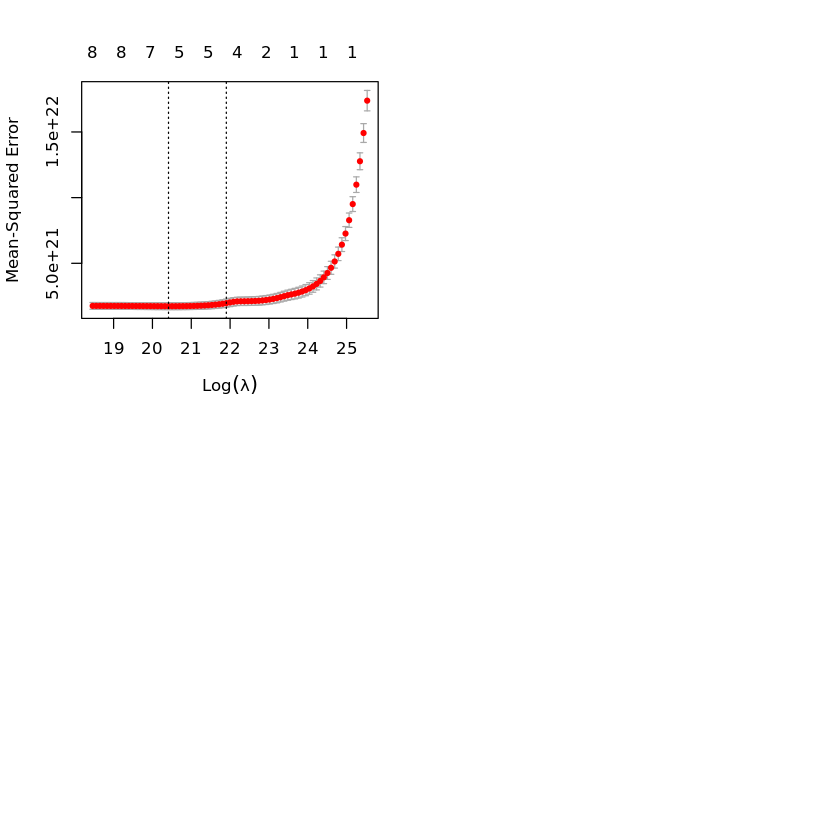

In [38]:
par(mfrow = c(2,2))
plot(lasso_model)

- I guess this is the only plot so we don't check for LINE aasumptins casuse Prophet is a semi-parametric model

### E. Performance Metrics

In [39]:
# Extract best lambda values
best_lambda <- lasso_model$lambda.min  # Lambda that gives minimum cross-validation error
best_lambda

[1] 733914775

In [40]:
# Predict on testing data
lasso_predictions <- predict(lasso_model, s = best_lambda, newx = X_test_lasso)

# Evaluate performance (e.g., Mean Squared Error)
MSE <- mean((y_test_lasso - lasso_predictions)^2)
print(MSE)

[1] NA


In [41]:

# Evaluate performance MAPE
MAPE <- mean(abs(y_test_lasso - lasso_predictions)/y_test_lasso)*100
print(MAPE)


[1] NA


- On average, the model's predictions are off by about 13% of the actual values. 

# Part 6: Add the regression into our model

## Step 1: Plugging Regressors into Prophet

- With a MAPE of 34%, it’s not ideal, but it’s not a dealbreaker
- Even if the Lasso model's MAPE is high, the regressors may still contain useful signals that Prophet can leverage.
- Prophet doesn't rely solely on the regressors—it also models time-based trends and seasonality, which can compensate for some of the inaccuracy in the regressors.

In [42]:
prophet_data_2 <- data.frame(
    ds = deposit_regressor_data$time_as_date,
    y = deposit_regressor_data$deposits,
    GDP = deposit_regressor_data$GDP,
    unemployment_rate = deposit_regressor_data$unemployment_rate,
    fed_rate = deposit_regressor_data$fed_rate,
    ConsumerPriceIndex = deposit_regressor_data$ConsumerPriceIndex # stop here if it makes things worse
    )
# Handle Consumer price index last missing value
prophet_data_2$ConsumerPriceIndex[is.na(prophet_data_2$ConsumerPriceIndex)] <- mean(prophet_data_2$ConsumerPriceIndex, na.rm = TRUE)

head(prophet_data_2)
tail(prophet_data_2)

,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1984-01-01,22917257000,3.908054e+12,0.07866667,0.09686667,1.1202636
2,1984-04-01,23575192000,4.009601e+12,0.07433333,0.10556667,1.0752688
3,1984-07-01,24308965000,4.084250e+12,0.07433333,0.11390000,1.0960671
4,1984-10-01,24967964000,4.148551e+12,0.07300000,0.09266667,0.7334184
5,1985-01-01,25673746000,4.230168e+12,0.07233333,0.08476667,0.6331117
6,1985-04-01,26941332000,4.294887e+12,0.07300000,0.07923333,1.2268009


,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
157,2023-01-01,361631019000,2.716436e+13,0.03500000,0.04516667,1.0449066
158,2023-04-01,361428409000,2.745382e+13,0.03566667,0.04990000,1.1923322
159,2023-07-01,361265548000,2.796770e+13,0.03700000,0.05260000,0.8664265
160,2023-10-01,352951195000,2.829697e+13,0.03733333,0.05330000,0.1045077
161,2024-01-01,353246439000,2.862407e+13,0.03800000,0.05330000,1.0425755
162,2024-04-01,349452050000,2.901671e+13,0.04000000,0.05330000,0.7006791


In [43]:
# Step 3: Initialize the model by adding on regressors and Fit Prophet

# Initialize the model
prophet_model_2 <- prophet()

# Add regressors
prophet_model_2 <- add_regressor(prophet_model_2, 'GDP')
prophet_model_2 <- add_regressor(prophet_model_2, 'unemployment_rate')
prophet_model_2 <- add_regressor(prophet_model_2, 'ConsumerPriceIndex')
prophet_model_2 <- add_regressor(prophet_model_2, 'fed_rate')


# Step 2: Fit the model: full data the model
prophet_model_2 <- fit.prophet(prophet_model_2, prophet_data_2) # syntax


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [44]:
# Step 4: Create a future dataframe
future_data_2 <- make_future_dataframe(prophet_model_2, periods = 15, freq = "quarter") # start counting from the end of the training data: 2020 Q4 to 2028 Q1
#future_data_2  # The output of make_future_dataframe() will include both the training data dates and the newly created future dates.future_train_data_2

In [ ]:
# Step 1: Create dataframes for GDP and unemployment rate
gdp_data <- data.frame(
  ds = prophet_data_2$ds, # Use the same date column as in your training data
  y = prophet_data_2$GDP  # Use the GDP column
)

unemployment_data <- data.frame(
  ds = prophet_data_2$ds, # Use the same date column as in your training data
  y = prophet_data_2$unemployment_rate # Use the unemployment rate column
)

fed_data <- data.frame(
  ds = prophet_data_2$ds, # Use the same date column as in your training data
  y = prophet_data_2$fed_rate # Use the fed rate column
)

CPI_data <- data.frame(
  ds = prophet_data_2$ds, # Use the same date column as in your training data
  y = prophet_data_2$ConsumerPriceIndex # Use the CPI column
) 

# Step 2: Fit Prophet models for GDP and unemployment rate
gdp_model <- prophet(gdp_data) # Fit the GDP model
unemployment_model <- prophet(unemployment_data) # Fit the unemployment rate model
fed_model <- prophet(fed_data)
CPI_model <- prophet(CPI_data)

# Step 3: Generate future dataframes matching the number of rows in future_data_2
future_gdp <- make_future_dataframe(gdp_model, periods = nrow(future_data_2) - nrow(prophet_data_2), freq = "quarter")
future_unemployment <- make_future_dataframe(unemployment_model, periods = nrow(future_data_2) - nrow(prophet_data_2), freq = "quarter")
future_fed <- make_future_dataframe(fed_model, periods = nrow(future_data_2) - nrow(prophet_data_2), freq = "quarter")
future_CPI <- make_future_dataframe(CPI_model, periods = nrow(future_data_2) - nrow(prophet_data_2), freq = "quarter")

# Step 4: Forecast the future regressor values
gdp_forecast <- predict(gdp_model, future_gdp)
unemployment_forecast <- predict(unemployment_model, future_unemployment)
fed_forecast <- predict(fed_model, future_fed)
CPI_forcast <- predict(CPI_model, future_CPI)

# Step 5: Extract forecasted values for GDP and unemployment rate
future_GDP_values <- gdp_forecast$yhat[(nrow(prophet_data_2) + 1):nrow(future_gdp)]
future_unemployment_values <- unemployment_forecast$yhat[(nrow(prophet_data_2) + 1):nrow(future_unemployment)]
future_fed_rate_values <- fed_forecast$yhat[(nrow(prophet_data_2) + 1):nrow(future_fed)]
future_CPI_values <- CPI_forcast$yhat[(nrow(prophet_data_2) + 1):nrow(future_CPI)]

# Step 6: Add future GDP and unemployment rate values to future_data_2
future_data_2$GDP <- c(prophet_data_2$GDP, future_GDP_values) # Combine training and future GDP values
future_data_2$unemployment_rate <- c(prophet_data_2$unemployment_rate, future_unemployment_values) # Combine training and future unemployment rate values
future_data_2$fed_rate <- c(prophet_data_2$fed_rate, future_fed_rate_values) 
future_data_2$ConsumerPriceIndex <- c(prophet_data_2$ConsumerPriceIndex, future_CPI_values) 

# Step 7: Verify the updated future_data_2

head(future_data_2) # Check the final dataframe with added co
tail(future_data_2)



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



,ds,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,1984-01-01,3.908054e+12,0.07866667,0.09686667,1.1202636
2,1984-04-01,4.009601e+12,0.07433333,0.10556667,1.0752688
3,1984-07-01,4.084250e+12,0.07433333,0.11390000,1.0960671
4,1984-10-01,4.148551e+12,0.07300000,0.09266667,0.7334184
5,1985-01-01,4.230168e+12,0.07233333,0.08476667,0.6331117
6,1985-04-01,4.294887e+12,0.07300000,0.07923333,1.2268009


,ds,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
172,2026-10-01,3.074056e+13,0.04847136,0.01356259,0.1866695
173,2027-01-01,3.101400e+13,0.04851470,0.01373128,0.6268033
174,2027-04-01,3.134867e+13,0.04912250,0.01424589,0.9463685
175,2027-07-01,3.168483e+13,0.04840287,0.01478801,0.5322882
176,2027-10-01,3.200047e+13,0.04737211,0.01423323,0.1834291
177,2028-01-01,3.225575e+13,0.04756654,0.01446437,0.6208651


In [46]:
# Step 6: Predict Future Values
prediction_data_2 <- predict(prophet_model_2, future_data_2)

In [47]:
saveRDS(prediction_data_2, "prediction_data_2.rds")  # Save the data to call it in other notebooks

In [48]:
prediction_data_2

ds,trend,additive_terms,additive_terms_lower,additive_terms_upper,ConsumerPriceIndex,ConsumerPriceIndex_lower,ConsumerPriceIndex_upper,extra_regressors_additive,extra_regressors_additive_lower,⋯,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,27572781189,-3790158907,-3790158907,-3790158907,1229882651,1229882651,1229882651,-10200712776,-10200712776,⋯,6410553869,6410553869,0,0,0,102215221,45823915138,27572781189,27572781189,23782622282
1984-04-01,27732006001,4163971012,4163971012,4163971012,1097994323,1097994323,1097994323,-4565423817,-4565423817,⋯,8729394829,8729394829,0,0,0,6626847175,56403402832,27732006001,27732006001,31895977013
1984-07-01,27891230812,13185453803,13185453803,13185453803,1158957949,1158957949,1158957949,722340119,722340119,⋯,12463113684,12463113684,0,0,0,19219966483,65206957138,27891230812,27891230812,41076684615
1984-10-01,28052205347,309817758,309817758,309817758,95964975,95964975,95964975,-12303971219,-12303971219,⋯,12613788977,12613788977,0,0,0,2490968249,51512966687,28052205347,28052205347,28362023105
1985-01-01,28213179882,-6888620236,-6888620236,-6888620236,-198053010,-198053010,-198053010,-16747733550,-16747733550,⋯,9859113314,9859113314,0,0,0,-2421426570,45166620583,28213179882,28213179882,21324559646
1985-04-01,28370654970,-10371368504,-10371368504,-10371368504,1542163915,1542163915,1542163915,-17925370309,-17925370309,⋯,7554001805,7554001805,0,0,0,-6551588663,40280577166,28370654970,28370654970,17999286466
1985-07-01,28529879773,-9215108645,-9215108645,-9215108645,41184741,41184741,41184741,-19050250922,-19050250922,⋯,9835142277,9835142277,0,0,0,-5764866186,42569853109,28529879773,28529879773,19314771128
1985-10-01,28690854299,-6415115942,-6415115942,-6415115942,568963220,568963220,568963220,-16974850952,-16974850952,⋯,10559735010,10559735010,0,0,0,-1850879944,45957339373,28690854299,28690854299,22275738357
1986-01-01,28851828825,-11534391856,-11534391856,-11534391856,-1426352850,-1426352850,-1426352850,-20254358019,-20254358019,⋯,8719966163,8719966163,0,0,0,-7007167865,39813143099,28851828825,28851828825,17317436969


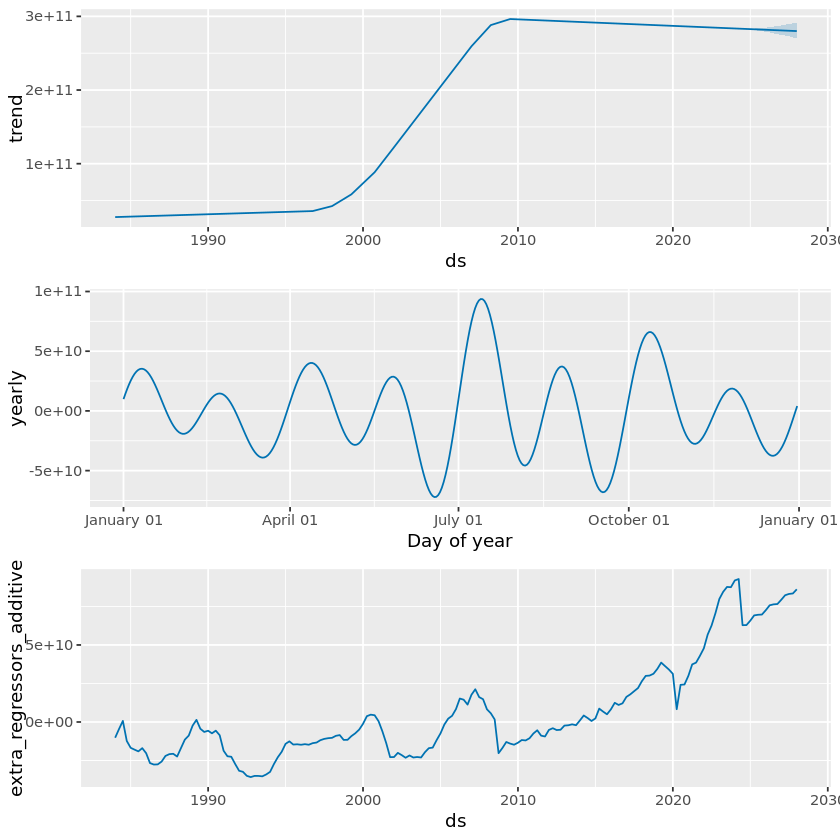

In [49]:
prophet_plot_components(prophet_model_2, prediction_data_2)

## Step 2: Visualize the foreacast

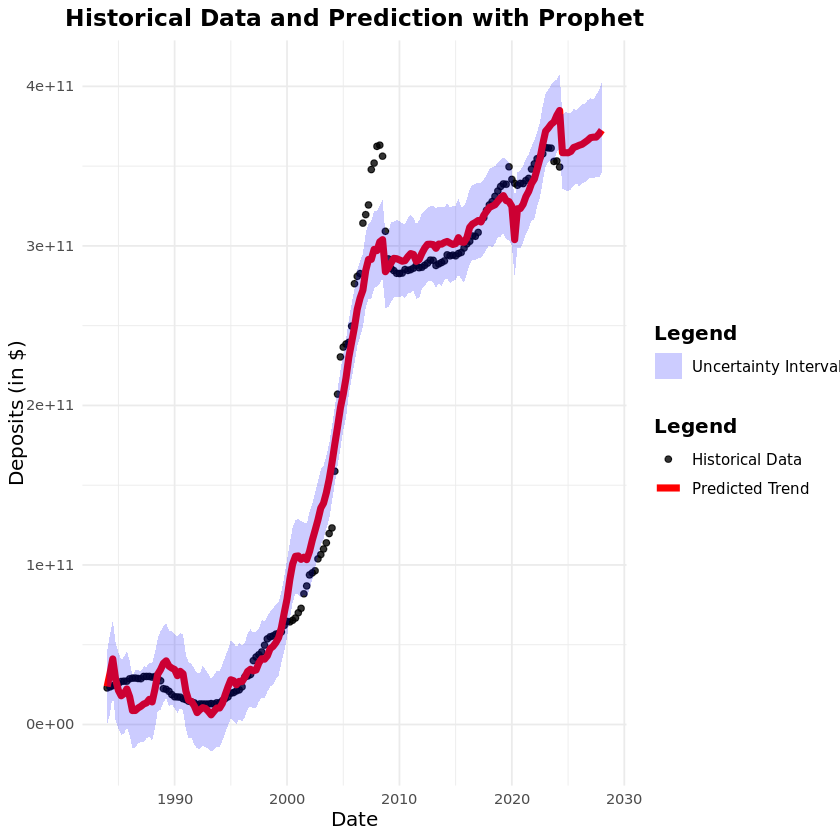

In [50]:
# Ensure 'ds' is a Date object
prophet_data_2$ds <- as.Date(prophet_data_2$ds)
prediction_data_2$ds <- as.Date(prediction_data_2$ds)

ggplot() +
  # Add historical data points
  geom_point(data = prophet_data_2, aes(x = ds, y = y, color = "Historical Data"), size = 1.5, alpha = 0.8) +
  # Add the predicted trend line
  geom_line(data = prediction_data_2, aes(x = ds, y = yhat, color = "Predicted Trend"), size = 2) +
  # Add uncertainty intervals for predictions
  geom_ribbon(
    data = prediction_data_2,
    aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Uncertainty Interval"),
    alpha = 0.2
  ) +
  # Add labels and a title
  labs(
    title = "Historical Data and Prediction with Prophet",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend",
    fill = "Legend"
  ) +
  # Customize colors for the legend
  scale_color_manual(
    values = c("Historical Data" = "black", "Predicted Trend" = "red")
  ) +
  scale_fill_manual(
    values = c("Uncertainty Interval" = "blue")
  ) +
  # Add a minimal theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 9)
  )

## Step 3: Evaluation of the Model Performance

You don't need to use make_future_dataframe() again for the test data if you already have test_data_2. The test data already contains the actual dates and regressors needed for evaluation.

In [51]:

# Step 1: Split Data between training and test data
train_data_2 <- subset(prophet_data_2, ds <= "2019-12-31") # Training data: 1984 Q1 to 2020 Q4
test_data_2 <- subset(prophet_data_2, ds > "2019-12-31")  # Testing data: 2021 Q1 to 2024 Q2

# Step 2: Prepare data for prophet to work
# you have to rename them as ds and y for prophet to work and it will automatically ignore all other columns ==> RULE
train_data_2$ds <- as.Date(train_data_2$ds)
train_data_2$y <- train_data_2$y

test_data_2$ds <- as.Date(test_data_2$ds)
test_data_2$y <- test_data_2$y

# Check
head(train_data_2)
tail(test_data_2)

,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1984-01-01,22917257000,3.908054e+12,0.07866667,0.09686667,1.1202636
2,1984-04-01,23575192000,4.009601e+12,0.07433333,0.10556667,1.0752688
3,1984-07-01,24308965000,4.084250e+12,0.07433333,0.11390000,1.0960671
4,1984-10-01,24967964000,4.148551e+12,0.07300000,0.09266667,0.7334184
5,1985-01-01,25673746000,4.230168e+12,0.07233333,0.08476667,0.6331117
6,1985-04-01,26941332000,4.294887e+12,0.07300000,0.07923333,1.2268009


,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
157,2023-01-01,361631019000,2.716436e+13,0.03500000,0.04516667,1.0449066
158,2023-04-01,361428409000,2.745382e+13,0.03566667,0.04990000,1.1923322
159,2023-07-01,361265548000,2.796770e+13,0.03700000,0.05260000,0.8664265
160,2023-10-01,352951195000,2.829697e+13,0.03733333,0.05330000,0.1045077
161,2024-01-01,353246439000,2.862407e+13,0.03800000,0.05330000,1.0425755
162,2024-04-01,349452050000,2.901671e+13,0.04000000,0.05330000,0.7006791


In [52]:
# Step 2: Initialize the model by adding on regressors and Fit Prophet

# Initialize the model
prophet_model_test <- prophet()

# Add regressors
prophet_model_test <- add_regressor(prophet_model_test, 'GDP')
prophet_model_test <- add_regressor(prophet_model_test, 'unemployment_rate')
prophet_model_test <- add_regressor(prophet_model_test, 'ConsumerPriceIndex')
prophet_model_test <- add_regressor(prophet_model_test, 'fed_rate')

# Step 2: Fit the model: Training the model
prophet_model_test <- fit.prophet(prophet_model_test, train_data_2) # syntax

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [53]:
future_test_data_2 <- make_future_dataframe(prophet_model_test, periods = nrow(test_data_2), freq = 'quarter')


In [54]:
# Train models for GDP and unemployment rate, CPI and fed rate
# You do not need to forcast them since here you alraedy have the values for the test dataframe
future_test_data_2$GDP <- test_data_2$GDP
future_test_data_2$unemployment_rate <- test_data_2$unemployment_rate
future_test_data_2$ConsumerPriceIndex <- test_data_2$ConsumerPriceIndex
future_test_data_2$fed_rate <- test_data_2$fed_rate


In [55]:

head(future_test_data_2) # Check the final dataframe with added co
tail(future_test_data_2)


,ds,GDP,unemployment_rate,ConsumerPriceIndex,fed_rate
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,1984-01-01,2.172766e+13,0.03833333,0.4194274,0.0126000000
2,1984-04-01,1.993544e+13,0.13000000,-0.5400354,0.0006000000
3,1984-07-01,2.168455e+13,0.08800000,1.1314854,0.0009333333
4,1984-10-01,2.206877e+13,0.06733333,0.2299503,0.0009000000
5,1985-01-01,2.265679e+13,0.06233333,1.0731144,0.0008000000
6,1985-04-01,2.336886e+13,0.05933333,2.3397887,0.0007000000


,ds,GDP,unemployment_rate,ConsumerPriceIndex,fed_rate
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
157,2023-01-01,2.716436e+13,0.03500000,1.0449066,0.04516667
158,2023-04-01,2.745382e+13,0.03566667,1.1923322,0.04990000
159,2023-07-01,2.796770e+13,0.03700000,0.8664265,0.05260000
160,2023-10-01,2.829697e+13,0.03733333,0.1045077,0.05330000
161,2024-01-01,2.862407e+13,0.03800000,1.0425755,0.05330000
162,2024-04-01,2.901671e+13,0.04000000,0.7006791,0.05330000


In [56]:
# Predict for the test period
forecast_test <- predict(prophet_model_test, future_test_data_2)
forecast_test

ds,trend,additive_terms,additive_terms_lower,additive_terms_upper,ConsumerPriceIndex,ConsumerPriceIndex_lower,ConsumerPriceIndex_upper,extra_regressors_additive,extra_regressors_additive_lower,⋯,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,207672788629,1.093496e+12,1.093496e+12,1.093496e+12,-160752236,-160752236,-160752236,7.331545e+11,7.331545e+11,⋯,360341663358,360341663358,0,0,0,1.288816e+12,1.313987e+12,207672788629,207672788629,1.301169e+12
1984-04-01,201429159439,9.496482e+11,9.496482e+11,9.496482e+11,-824737776,-824737776,-824737776,5.878195e+11,5.878195e+11,⋯,361828604004,361828604004,0,0,0,1.139715e+12,1.163625e+12,201429159439,201429159439,1.151077e+12
1984-07-01,195185530249,1.086232e+12,1.086232e+12,1.086232e+12,332019516,332019516,332019516,7.210838e+11,7.210838e+11,⋯,365148620106,365148620106,0,0,0,1.269337e+12,1.292766e+12,195185530249,195185530249,1.281418e+12
1984-10-01,188873289749,1.115525e+12,1.115525e+12,1.115525e+12,-291877796,-291877796,-291877796,7.519353e+11,7.519353e+11,⋯,363589548135,363589548135,0,0,0,1.291888e+12,1.316897e+12,188873289749,188873289749,1.304398e+12
1985-01-01,182561049250,1.159163e+12,1.159163e+12,1.159163e+12,291624535,291624535,291624535,7.950014e+11,7.950014e+11,⋯,364161841709,364161841709,0,0,0,1.328887e+12,1.353282e+12,182561049250,182561049250,1.341724e+12
1985-04-01,176386031369,1.208236e+12,1.208236e+12,1.208236e+12,1168212330,1168212330,1168212330,8.466671e+11,8.466671e+11,⋯,361568928344,361568928344,0,0,0,1.373030e+12,1.397676e+12,176386031369,176386031369,1.384622e+12
1985-07-01,170142402223,1.249929e+12,1.249929e+12,1.249929e+12,656924783,656924783,656924783,8.869372e+11,8.869372e+11,⋯,362991848301,362991848301,0,0,0,1.408022e+12,1.432694e+12,170142402223,170142402223,1.420071e+12
1985-10-01,163830161766,1.311512e+12,1.311512e+12,1.311512e+12,599337542,599337542,599337542,9.490190e+11,9.490190e+11,⋯,362493381649,362493381649,0,0,0,1.463445e+12,1.487184e+12,163830161766,163830161766,1.475343e+12
1986-01-01,157517921310,1.344326e+12,1.344326e+12,1.344326e+12,1129233781,1129233781,1129233781,9.811679e+11,9.811679e+11,⋯,363158004032,363158004032,0,0,0,1.489632e+12,1.513530e+12,157517921310,157517921310,1.501844e+12


In [57]:

# Merge predictions with actual test data: 

forecast_test$ds <- as.Date(forecast_test$ds) #make sure ds is in date format or else merge will fail

# The merging step combines your actual test data with the predictions generated by Prophet. This creates a single dataframe where you can directly compare the actual (y) and predicted (yhat) values for each time point (ds)
forecast_test_results <- merge(test_data_2, forecast_test[, c("ds", "yhat")], by = "ds")
forecast_test_results

ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex,yhat
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-01,341691380000,2.172766e+13,0.03833333,0.0126000000,0.4194274,334941239745
2020-04-01,339227043000,1.993544e+13,0.13000000,0.0006000000,-0.5400354,179769936859
2020-07-01,338020161000,2.168455e+13,0.08800000,0.0009333333,1.1314854,305030844997
2020-10-01,339166813000,2.206877e+13,0.06733333,0.0009000000,0.2299503,322875551538
2021-01-01,339070926000,2.265679e+13,0.06233333,0.0008000000,1.0731144,355066212751
2021-04-01,340991443000,2.336886e+13,0.05933333,0.0007000000,2.3397887,392940056633
2021-07-01,342317919000,2.392199e+13,0.05066667,0.0009000000,1.6009753,423309809880
2021-10-01,348156945000,2.477704e+13,0.04166667,0.0008000000,1.5177614,473445408682
2022-01-01,351425943000,2.521549e+13,0.03800000,0.0012000000,2.2834645,494811183142


In [58]:

# Extract actual values from test data
actual <- test_data_2$y

# Extract predictions (yhat) from forecast_test for the same dates as test_data_2
predicted <- forecast_test$yhat

# Calculate performance metrics
mae <- mae(actual, predicted)
rmse <- rmse(actual, predicted)
mape <- mape(actual, predicted) * 100  # Convert to percentage

# Calculate naive forecast error
naive_forecast <- actual[-1]  # Naive forecast: use previous value
naive_actual <- actual[-length(actual)]  # Exclude first value to align with naive forecast
naive_mae <- mean(abs(naive_forecast - naive_actual))

# Calculate MASE
mase <- mae / naive_mae

# Calculate R²
ss_total <- sum((actual - mean(actual))^2)
ss_residual <- sum((actual - predicted)^2)
r_squared <- 1 - (ss_residual / ss_total)

# Print metrics
print(paste("MAE:", round(mae, 2)))
print(paste("RMSE:", round(rmse, 2)))
print(paste("MAPE:", round(mape, 2), "%"))
print(paste("MASE:", round(mase, 2)))
print(paste("R²:", round(r_squared, 2)))



[1] "MAE: 705367975325.99"
[1] "RMSE: 780789453368.88"
[1] "MAPE: 201.22 %"
[1] "MASE: 297.97"
[1] "R²: -80521.8"


In [59]:
# Calculate naive forecast
naive_forecast <- c(NA, head(test_data_2$y, -1))  # Shift y_test by one step for naive forecast

# Create a data frame for plotting
naive_vs_model <- data.frame(
  Date = test_data_2$ds,  # Dates from test data
  Actual_Deposits = test_data_2$y,  # Actual deposit values
  Naive_Forecast = naive_forecast,  # Naive forecast values
  Predicted_Deposits = prediction_test_results_2$yhat  # Predicted deposit values
)

# Plot the data
library(ggplot2)
ggplot(naive_vs_model, aes(x = Date)) +
  geom_line(aes(y = Actual_Deposits, color = "Actual Deposits"), size = 2) +  # Line for actual deposits
  geom_line(aes(y = Naive_Forecast, color = "Naive Forecast"), size = 2, linetype = "dotted") +  # Dotted line for naive forecast
  geom_line(aes(y = Predicted_Deposits, color = "Predicted Deposits"), size = 2, linetype = "dashed") +  # Dashed line for model predictions
  labs(
    title = "Actual vs Naive vs Predicted Deposits (2020-2024)",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  )


ERROR: Error in data.frame(Date = test_data_2$ds, Actual_Deposits = test_data_2$y, : object 'prediction_test_results_2' not found
